In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

from src import config
from src.get_data import get_file_data_label

import torch


import time
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Compose, 
    LoadImaged, 
    MapTransform, 
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    Spacingd,
    NormalizeIntensityd,
    RandSpatialCropd,
    Activations,
    AsDiscrete,
    )
from monai.data import (Dataset, DataLoader)
from monai.utils import first
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

import matplotlib.pyplot as plt

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
py

In [4]:
# Get train and validation dataset. 
# train_files and val_files are a List[Dict] ->[{'image':[paths of images], 'label':[paths of labels]}

train_files= get_file_data_label(config.DATA_TRAIN, config.LABEL_TRAIN)
val_files=get_file_data_label(config.DATA_TEST, config.LABEL_TEST)

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is necrosis
    label 2 is edema
    label 3 is activo
    The possible classes are N (necrosis), E (edema)
    and TA (active).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # label 1 necro
            result.append(d[key] == 1)
            # label 2 is ET
            result.append(d[key] == 2)
            # merge labels 3, 4 and 3 to construct activo
            result.append(torch.logical_or(d[key] == 3, d[key] == 4))
            
            d[key] = torch.stack(result, axis=0).float()
        return d

In [6]:
# Do transformations to create tensors
from monai.transforms import GridPatchd, SplitDimd, SpatialCropd

train_transform = Compose([
        LoadImaged(keys=["image", "label"], image_only=False),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        
])

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=False),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [7]:
# Cerate ieterable Dataset using train files and the respective Dataloader
train_ds = Dataset(data=train_files,transform=train_transform, )
train_loader = DataLoader(train_ds, batch_size=1, ) #num_workers=8

val_ds = Dataset(data=val_files,transform=val_transform, )
val_loader = DataLoader(val_ds, batch_size=1,) #num_workers=8

In [8]:
# Get one batch for the Dataloader and chek tensor dimensions of Data and labels
patient=first(val_loader)
print('Images: ',patient['image'].shape)
print('Labels: ', patient['label'].shape)

Images:  torch.Size([1, 11, 240, 240, 155])
Labels:  torch.Size([1, 3, 240, 240, 155])


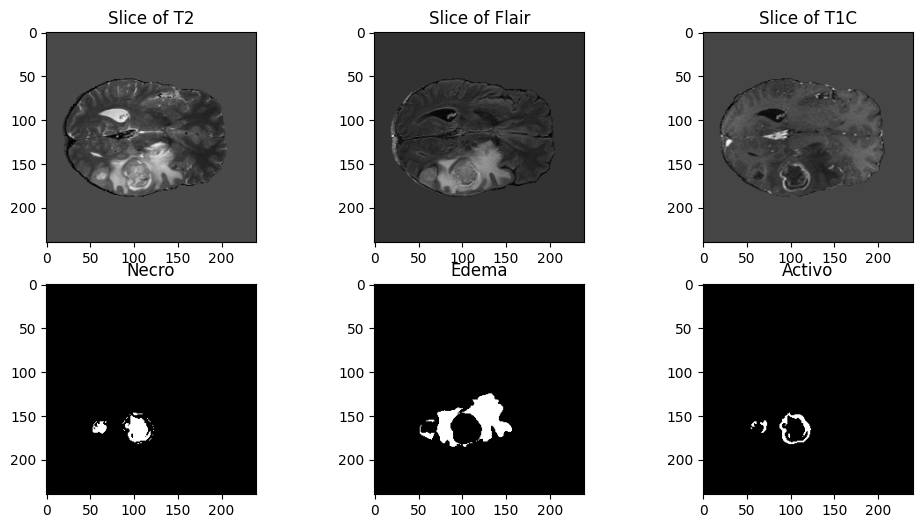

In [9]:

sl = 60
idx=0
plt.figure('patient',(12,6))

plt.subplot(2,3,1)
plt.title('Slice of T2')
plt.imshow(patient['image'][idx,10,:,:,sl], cmap='gray')

plt.subplot(2,3,2)
plt.title('Slice of Flair')
plt.imshow(patient['image'][idx,7,:,:,sl], cmap='gray')

plt.subplot(2,3,3)
plt.title('Slice of T1C')
plt.imshow(patient['image'][idx,9,:,:,sl], cmap='gray')


plt.subplot(2,3,4)
plt.title('Necro')
plt.imshow(patient['label'][idx,0,:,:,sl], cmap='gray')

plt.subplot(2,3,5)
plt.title('Edema')
plt.imshow(patient['label'][idx,1,:,:,sl], cmap='gray')

plt.subplot(2,3,6)
plt.title('Activo')
plt.imshow(patient['label'][idx,2,:,:,sl], cmap='gray')

In [13]:
max_epochs = 1
val_interval = 1
VAL_AMP = False

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SegResNet( 
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=11,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# use amp to accelerate training
#scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
#torch.backends.cudnn.benchmark = True



In [14]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = loss_function(outputs, labels)    # calculamos la pérdida
        loss.backward()                 # calculamos los gradientes
        optimizer.step()                # actualizamos los parámetros
    
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(config.MODEL_PATH, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" Necro: {metric_tc:.4f} Edema: {metric_wt:.4f} TA: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/1
1/10, train_loss: 0.9984, step time: 36.2208
2/10, train_loss: 0.9612, step time: 33.3644
3/10, train_loss: 0.9798, step time: 33.7484
4/10, train_loss: 0.9823, step time: 36.1227
5/10, train_loss: 0.9725, step time: 36.8385
6/10, train_loss: 0.9729, step time: 37.8376
7/10, train_loss: 0.9672, step time: 36.1254
8/10, train_loss: 0.9870, step time: 37.2033
9/10, train_loss: 0.9472, step time: 36.0717
10/10, train_loss: 0.9866, step time: 36.1111
epoch 1 average loss: 0.9755
saved new best metric model
current epoch: 1 current mean dice: 0.1529 Necro: 0.0881 Edema: 0.3670 TA: 0.0037
best mean dice: 0.1529 at epoch: 1
time consuming of epoch 1 is: 394.2267


In [15]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.1529 at epoch: 1, total time: 394.2327263355255.
